In [1]:
import pandas as pd
df = pd.read_csv("car_fuel_efficiency.csv")

# 1: missing value
columns_to_use = [
    'engine_displacement',
    'horsepower', 
    'vehicle_weight',
    'model_year',
    'fuel_efficiency_mpg'
]

df = df[columns_to_use]
df.head()
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [2]:
# 2: medion for horsepower
print(df['horsepower'].median())

149.0


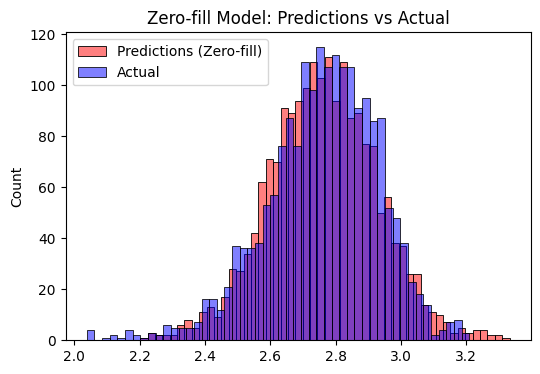

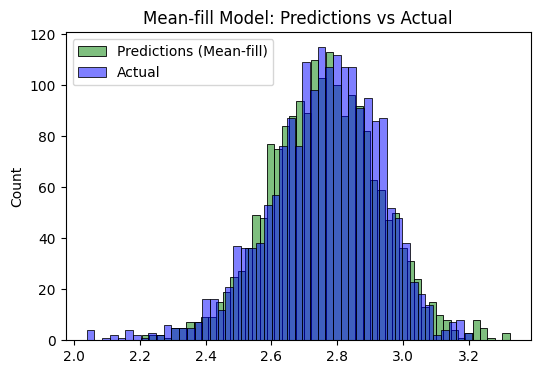

In [3]:
# 3
# data preparation
import numpy as np
# split the data to 60 train, 20 val, 20 test
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
y_test = np.log1p(df_test.fuel_efficiency_mpg.values)

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

# option 1: fill missing value in horsepower with zero
df_train_zero = df_train.copy()
df_train_zero['horsepower'] = df_train_zero['horsepower'].fillna(0)

# option 2: fill missing value in horsepower with mean
df_train_mean = df_train.copy()
horsepower_mean = df_train_mean['horsepower'].mean()
df_train_mean['horsepower'] = df_train_mean['horsepower'].fillna(horsepower_mean)

def train_linear_regression(X,y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

# train both models missing value with zero and missing balue with mean
w0_zero, w_zero = train_linear_regression(df_train_zero, y_train)
w0_mean, w_mean = train_linear_regression(df_train_mean, y_train)

# prediction function
def predict_linear_regression(X, w0, w):
    return w0 + X.dot(w)

# prepare dataset val same way as train
df_val_zero = df_val.copy()
df_val_zero['horsepower'] = df_val_zero['horsepower'].fillna(0)

df_val_mean = df_val.copy()
df_val_mean['horsepower'] = df_val_mean['horsepower'].fillna(horsepower_mean)

# make predictions on val data
y_pred_zero_val = predict_linear_regression(df_val_zero, w0_zero, w_zero)
y_pred_mean_val = predict_linear_regression(df_val_mean, w0_mean, w_mean)

# see the plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.histplot(y_pred_zero_val, color='red', bins=50, alpha=0.5, label='Predictions (Zero-fill)')
sns.histplot(y_val, color='blue', bins=50, alpha=0.5, label='Actual')
plt.title('Zero-fill Model: Predictions vs Actual')
plt.legend()
plt.show()

# Second figure: Mean-fill
plt.figure(figsize=(6, 4))
sns.histplot(y_pred_mean_val, color='green', bins=50, alpha=0.5, label='Predictions (Mean-fill)')
sns.histplot(y_val, color='blue', bins=50, alpha=0.5, label='Actual')
plt.title('Mean-fill Model: Predictions vs Actual')
plt.legend()
plt.show()

In [4]:
def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

rmse_zero_val = rmse(y_val, y_pred_zero_val)
rmse_mean_val = rmse(y_val, y_pred_mean_val)
print("Zero fill on horsepower:", rmse_zero_val)
print("Mean fill on horsepower:", rmse_mean_val)
# notes: with mean give better rsme score. it's lowet than with zero

Zero fill on horsepower: 0.03997925782374439
Mean fill on horsepower: 0.03732771701389712


In [5]:
# 4
# prepare the data - fill NAs with 0
df_train_reg = df_train.copy()
df_val_reg = df_val.copy()
df_train_reg['horsepower'] = df_train_reg['horsepower'].fillna(0)
df_val_reg['horsepower'] = df_val_reg['horsepower'].fillna(0)

# make sure all data is numeric (safety check)
df_train_reg = df_train_reg.apply(pd.to_numeric, errors='coerce').fillna(0)
df_val_reg = df_val_reg.apply(pd.to_numeric, errors='coerce').fillna(0)

# train linear regression with regularization
def train_linear_regression_reg(X,y,r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

# try different r values
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
results = []

for r in r_values:
    # train model with current r value
    w0, w = train_linear_regression_reg(df_train_reg, y_train, r=r)
    
    # make predictions on validation set
    y_pred_val = predict_linear_regression(df_val_reg, w0, w)
    
    # calculate RMSE and round to 2 decimal digits
    rmse_score = rmse(y_val, y_pred_val)
    rmse_rounded = round(rmse_score, 2)
    
    results.append((r, rmse_rounded, rmse_score))

results

[(0, np.float64(0.04), np.float64(0.03997925782374439)),
 (0.01, np.float64(0.04), np.float64(0.03997787201684389)),
 (0.1, np.float64(0.04), np.float64(0.04050873984529611)),
 (1, np.float64(0.04), np.float64(0.04135385150821747)),
 (5, np.float64(0.04), np.float64(0.04150611823271757)),
 (10, np.float64(0.04), np.float64(0.041526801237522025)),
 (100, np.float64(0.04), np.float64(0.04154575656081135))]

In [8]:
# 5
# list of seeds to try
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_scores = []

print("RMSE scores for different seeds:")
print("Seed\t|\tRMSE")
print("-" * 20)

for seed in seeds:
    # split the data with current seed
    n = len(df)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train_seed = df.iloc[idx[:n_train]]
    df_val_seed = df.iloc[idx[n_train:n_train+n_val]]
    df_test_seed = df.iloc[idx[n_train+n_val:]]

    df_train_seed = df_train_seed.reset_index(drop=True)
    df_val_seed = df_val_seed.reset_index(drop=True)
    df_test_seed = df_test_seed.reset_index(drop=True)

    # prepare target variable (log transformation)
    y_train_seed = np.log1p(df_train_seed.fuel_efficiency_mpg.values)
    y_val_seed = np.log1p(df_val_seed.fuel_efficiency_mpg.values)

    # remove target from features
    del df_train_seed['fuel_efficiency_mpg']
    del df_val_seed['fuel_efficiency_mpg']

    # fill missing values with 0 (as instructed)
    df_train_seed = df_train_seed.fillna(0)
    df_val_seed = df_val_seed.fillna(0)

    # make sure all data is numeric
    df_train_seed = df_train_seed.apply(pd.to_numeric, errors='coerce').fillna(0)
    df_val_seed = df_val_seed.apply(pd.to_numeric, errors='coerce').fillna(0)

    # train model without regularization
    w0, w = train_linear_regression(df_train_seed, y_train_seed)
    
    # make predictions on validation set
    y_pred_val = predict_linear_regression(df_val_seed, w0, w)
    
    # calculate RMSE
    rmse_score = rmse(y_val_seed, y_pred_val)
    rmse_scores.append(rmse_score)
    
    print(f"{seed}\t|\t{rmse_score:.4f}")

# calculate standard deviation and round to 3 decimal digits
std_dev = np.std(rmse_scores)
std_rounded = round(std_dev, 3)

print("\n" + "=" * 40)
print(f"RMSE Scores: {[round(score, 4) for score in rmse_scores]}")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f}")
print(f"Standard Deviation: {std_dev:.6f}")
print(f"Standard Deviation (rounded to 3 digits): {std_rounded}")
print("=" * 40)

RMSE scores for different seeds:
Seed	|	RMSE
--------------------
0	|	0.0380
1	|	0.0393
2	|	0.0394
3	|	0.0387
4	|	0.0373
5	|	0.0394
6	|	0.0389
7	|	0.0384
8	|	0.0402
9	|	0.0386

RMSE Scores: [np.float64(0.038), np.float64(0.0393), np.float64(0.0394), np.float64(0.0387), np.float64(0.0373), np.float64(0.0394), np.float64(0.0389), np.float64(0.0384), np.float64(0.0402), np.float64(0.0386)]
Mean RMSE: 0.0388
Standard Deviation: 0.000780
Standard Deviation (rounded to 3 digits): 0.001


In [10]:
# 6, same as most previous but use seed 9 for random and 0.01 for r value
np.random.seed(9)
idx_9 = np.arange(len(df))
np.random.shuffle(idx_9)

n_val_9 = int(len(df) * 0.2)
n_test_9 = int(len(df) * 0.2)
n_train_9 = len(df) - n_val_9 - n_test_9

df_train_9 = df.iloc[idx_9[:n_train_9]].reset_index(drop=True)
df_val_9 = df.iloc[idx_9[n_train_9:n_train_9+n_val_9]].reset_index(drop=True)
df_test_9 = df.iloc[idx_9[n_train_9+n_val_9:]].reset_index(drop=True)

# Combine train and validation
df_train_val_9 = pd.concat([df_train_9, df_val_9], axis=0).reset_index(drop=True)

# Prepare features and targets (with log transformation for training)
y_train_val_9_log = np.log1p(df_train_val_9.fuel_efficiency_mpg.values)
y_test_9_log = np.log1p(df_test_9.fuel_efficiency_mpg.values)

# Keep original values for final RMSE calculation
y_test_9_original = df_test_9.fuel_efficiency_mpg.values

X_train_val_9 = df_train_val_9.drop('fuel_efficiency_mpg', axis=1)
X_test_9 = df_test_9.drop('fuel_efficiency_mpg', axis=1)

# Fill missing values with 0
X_train_val_9 = X_train_val_9.fillna(0).apply(pd.to_numeric, errors='coerce').fillna(0)
X_test_9 = X_test_9.fillna(0).apply(pd.to_numeric, errors='coerce').fillna(0)

# Train model with r=0.001 on combined data (using log-transformed target)
w0_9, w_9 = train_linear_regression_reg(X_train_val_9, y_train_val_9_log, r=0.001)

# Make predictions (these are in log space)
y_pred_test_9_log = predict_linear_regression(X_test_9, w0_9, w_9)

# Convert predictions back to original scale
y_pred_test_9_original = np.expm1(y_pred_test_9_log)

# Calculate RMSE on original scale
rmse_test_9_original = rmse(y_test_9_original, y_pred_test_9_original)

print("\n" + "=" * 50)
print("FINAL RESULT:")
print(f"RMSE on test dataset (original scale): {rmse_test_9_original:.4f}")
print("=" * 50)


FINAL RESULT:
RMSE on test dataset (original scale): 0.6074
